In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from auxiliary import get_base_network_name
from auxiliary import getLinearReg, powerlaw

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

In [2]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    hist = np.histogram(comp_sizes, bins=bins, density=density)
    hist_norm = hist[0].astype('float')
    #print(hist_norm)
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

markers=['^', 's', 'p', 'h', '8']
def plot_comp_sizes(attack, comp_sizes, f_values, ax, nbins=None, 
                    log=True, density=True, colormap=None, nseeds=None):
    for i, f_value in enumerate(f_values):
        X, Y = get_histo(comp_sizes[f_value], nbins=nbins, log=log, density=density)
        if nseeds:
            Y = Y / nseeds
        label = r'${{{:.4f}}}$'.format(float(f_value))
        color = colormap[i] if colormap else 'C%d' % i
        #ax.plot(X, Y, '-' , marker='o', label=label, color=color)
        ax.plot(X, Y, markers[i] , label=label, color=color)

    return

In [67]:
attacks = [
    #'Ran', 'DegU', 
    'BtwU', 
    #'BtwU_cutoff2', 
    #'BtwU_cutoff3','BtwU_cutoff4', 
    #'BtwU_cutoff5', 'BtwU_cutoff6',
    #'BtwU_cutoff10', 'BtwU_cutoff11','BtwU_cutoff12','BtwU_cutoff13',
    #'BtwU_cutoff16', 'BtwU_cutoff54'
    #'BtwU_cutoff15'
]

In [68]:
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}
    all_comp_sizes_dict[attack] = {}

In [69]:
N = 16384
for attack in attacks:
    #N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [70]:
overwrite = False
if False:
    all_f_values = {
        #'BtwU': ['0.0435'] # N = 4096
        #'BtwU': ['0.04500', '0.04736', '0.05000', '0.05469'], # N = 2048
        #'BtwU': ['0.02500', '0.03000', '0.03500', '0.03750', '0.04000', '0.04350', '0.05000'], # N = 4096
        #'BtwU': [ '0.03000', '0.03250', '0.03500', '0.03750', '0.04000', '0.04250'],#, '0.05000'], # N = 4096
        #'BtwU': ['0.02000', '0.02250', '0.02500', '0.02750', '0.03000'], # N = 8192
        'BtwU': ['0.02000', '0.02200', '0.02400', '0.02500'], # N = 16384
        'DegU': ['0.37354'], # N = 2048
        'Ran': ['0.50977'], # N = 2048
        'BtwU_cutoff2': ['0.30000', '0.31000', '0.32000', '0.33000', '0.34000'], # N = 8192
        'BtwU_cutoff3': ['0.26000', '0.27000', '0.28000', '0.29000', '0.30000'], # N = 8192
        'BtwU_cutoff4': ['0.23000', '0.24000', '0.25000', '0.26000', '0.27000'], # N = 8192
        'BtwU_cutoff6': ['0.18000', '0.19000', '0.20000', '0.21000', '0.22000'], # N = 8192
        'BtwU_cutoff7': ['0.18000', '0.19000', '0.20000', '0.21000'], # N = 8192
        'BtwU_cutoff8': ['0.16000', '0.17000', '0.18000', '0.19000', '0.20000'], # N = 8192
        'BtwU_cutoff9': ['0.15000', '0.16000', '0.17000', '0.18000'], # N = 8192
        'BtwU_cutoff15': ['0.09000', '0.09500', '0.10000', '0.11000'] # N = 8192
    }

if N == 16384:
    all_f_values = {
        'BtwU': ['0.02000', '0.02200', '0.02400', '0.02500'], # N = 16384
    }
if N == 8192:
    all_f_values = {# N = 8192
        "BtwU": ["0.02633", "0.03650", "0.03198"],
        "BtwU_cutoff2": ["0.33537", "0.33813", "0.34106"],
        "BtwU_cutoff3": ["0.28012", "0.28259", "0.28442"],
        "BtwU_cutoff4": ["0.25069", "0.25183", "0.25476"],
        "BtwU_cutoff5": ["0.22539", "0.22754", "0.22961"],
        "BtwU_cutoff6": ["0.20464", "0.20618", "0.20801"],
        "BtwU_cutoff10": ["0.14397", "0.14490", "0.14819"],
        "BtwU_cutoff11": ["0.13367", "0.13403", "0.13843"],
        "BtwU_cutoff12": ["0.12413", "0.12598", "0.12769"],
        "BtwU_cutoff13": ["0.11607", "0.11670", "0.12158"],
        "BtwU_cutoff14": ["0.10764", "0.10864", "0.11365"],
        "BtwU_cutoff15": ["0.10160", "0.10181", "0.10706"],
        "BtwU_cutoff16": ["0.09638", "0.09534", "0.10156"],
        "BtwU_cutoff54": ["0.02644", "0.03711", "0.03259"]
    }
if N == 4096:
    all_f_values = {# N = 4096
        "BtwU_cutoff2": ["0.33373", "0.33594", "0.33887"],
        "BtwU_cutoff3": ["0.27857", "0.28076", "0.28540"],
        "BtwU_cutoff4": ["0.24841", "0.24951", "0.25464"],
        "BtwU_cutoff5": ["0.22305", "0.22510", "0.22803"],
        "BtwU_cutoff6": ["0.20151", "0.20288", "0.20703"],
        "BtwU_cutoff7": ["0.18301", "0.18506", "0.18823"],
        "BtwU_cutoff8": ["0.16664", "0.16797", "0.17334"],
        "BtwU_cutoff9": ["0.15233", "0.15259", "0.15796"],
        "BtwU_cutoff10": ["0.13978", "0.14160", "0.14600"],
        "BtwU_cutoff11": ["0.12871", "0.13062", "0.13403"],
        "BtwU_cutoff12": ["0.11903", "0.12158", "0.12451"],
        "BtwU_cutoff13": ["0.11023", "0.11328", "0.11646"],
        "BtwU_cutoff14": ["0.10261", "0.10571", "0.10913"],
        "BtwU_cutoff15": ["0.09549", "0.09937", "0.10156"],
    }
    
for attack in attacks:
    print(attack)
    
    gcc = False
    if attack in ['BtwU']:
        gcc = True
    gcc = True
    
    #N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        print(f_value)
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

BtwU
0.02000
0.02200
0.02400
0.02500


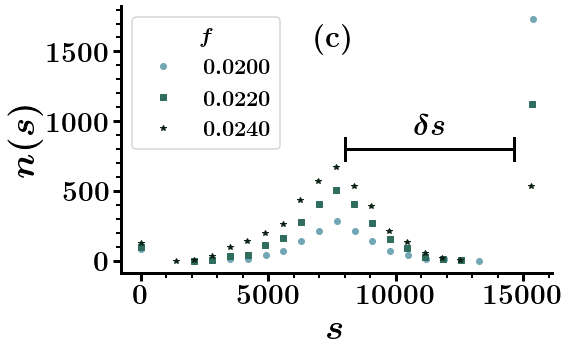

In [73]:
attack = 'BtwU'
ylim = (1E-6, 7)
xlim = (0.8, 5000)
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)

sns.despine()
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
#ax.set_ylabel(r'$p(s)$', fontsize=36)    
ax.set_ylabel(r'$n(s)$', fontsize=36)    

f_values = all_f_values[attack][:-1]

colormap = sns.cubehelix_palette(
    len(f_values), start=2, rot=0.3, light=0.6, dark=0.1
)

if N == 8192:
    delta_s = 3400
    X = np.array([0, delta_s]) + 4000
    y = 400
    dy = 0.1*y
    ax.plot(X, [y]*2, color='k')
    ax.plot([X[0]]*2, [y-dy, y+dy], color='k')
    ax.plot([X[1]]*2, [y-dy, y+dy], color='k')
    ax.text(0.68, 0.37, r'$\delta s$', transform=ax.transAxes, fontsize=30)
    
if N == 16384:
    delta_s = 6641
    X = np.array([0, delta_s]) + 8000
    y = 800
    dy = 0.1*y
    ax.plot(X, [y]*2, color='k')
    ax.plot([X[0]]*2, [y-dy, y+dy], color='k')
    ax.plot([X[1]]*2, [y-dy, y+dy], color='k')
    ax.text(0.68, 0.52, r'$\delta s$', transform=ax.transAxes, fontsize=30)

ax.autoscale()
ax.margins(0.05)

plot_comp_sizes(
    attack, all_comp_sizes_dict[attack][N], f_values, ax, nbins=24,
    log=False, colormap=colormap, density=False
)
legend = ax.legend(fontsize=22)
legend.set_title(r'$f$', prop={'size':22})

ax.text(0.45, 0.85, letters[2], transform=ax.transAxes, fontsize=30)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_RB_{}_N{}'.format(net_type, N))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

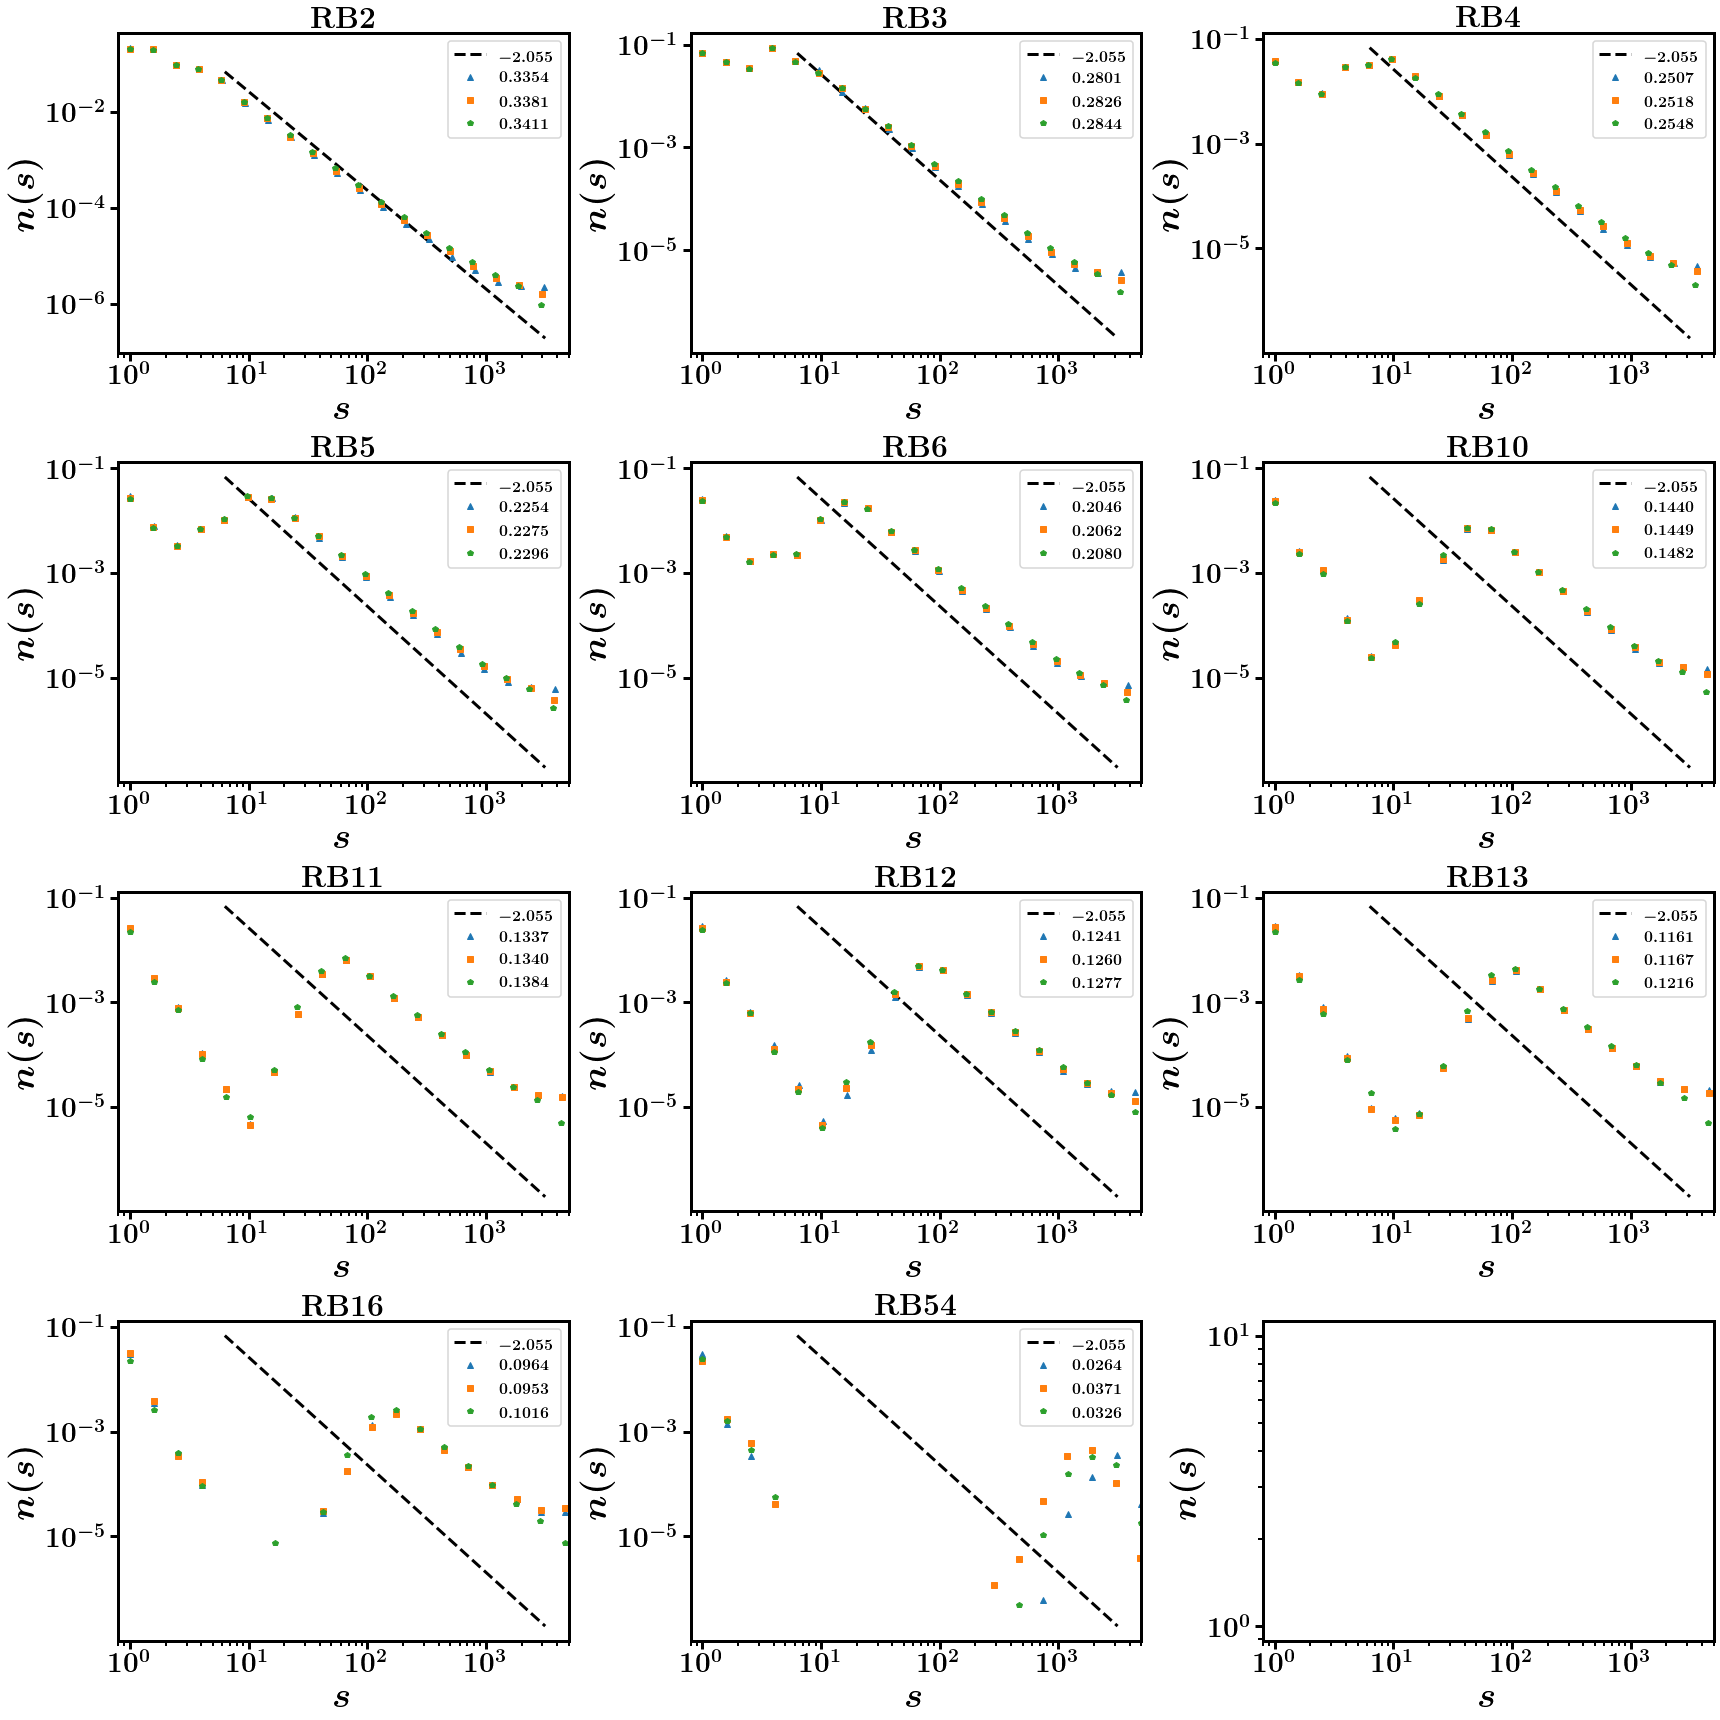

In [11]:
#if 'BtwU' in attacks:
#    attacks.remove('BtwU')
log = True

ylim = (1E-6, 7)
xlim = (0.8, 5000)
ncols = 3
nrows = len(attacks) // ncols
if len(attacks) % ncols:
    nrows += 1

fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$n(s)$', fontsize=36)    

for i, attack in enumerate(attacks):
    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=30)
    #N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    X = np.logspace(0.8, 3.5)
    a = -2.055
    #c = Y[4] / X[4]**a
    c = 3
    Y = powerlaw(X, a, c)
    ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
    
    plot_comp_sizes(
        attack, all_comp_sizes_dict[attack][N], f_values, ax, log=log, density=True#, nseeds=1000
    )
    ax.legend(fontsize=16)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_RBl_{}_N{}'.format(net_type, N))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [75]:
f_values_dict = {}
    
f_values_dict[16384] = {
    "BtwU": ["0.02202", "0.02985", "0.02692"]
    }    
    
f_values_dict[8192] = {
    "BtwU": ["0.02633", "0.03650", "0.03198"],
    "BtwU_cutoff2": ["0.33537", "0.33813", "0.34106"],
    "BtwU_cutoff3": ["0.28012", "0.28259", "0.28442"],
    "BtwU_cutoff4": ["0.25069", "0.25183", "0.25476"],
    "BtwU_cutoff5": ["0.22539", "0.22754", "0.22961"],
    "BtwU_cutoff6": ["0.20464", "0.20618", "0.20801"],
    "BtwU_cutoff10": ["0.14397", "0.14490", "0.14819"],
    "BtwU_cutoff11": ["0.13367", "0.13403", "0.13843"],
    "BtwU_cutoff12": ["0.12413", "0.12598", "0.12769"],
    "BtwU_cutoff13": ["0.11607", "0.11670", "0.12158"],
    "BtwU_cutoff14": ["0.10764", "0.10864", "0.11365"],
    "BtwU_cutoff15": ["0.10160", "0.10181", "0.10706"],
    "BtwU_cutoff16": ["0.09571", "0.09534", "0.10156"],
    "BtwU_cutoff54": ["0.02644", "0.03711", "0.03259"]
}

f_values_dict[4096] = {
    "BtwU": ["0.03188", "0.04663", "0.03882"],
    "BtwU_cutoff2": ["0.33373", "0.33594", "0.33887"],
    "BtwU_cutoff3": ["0.27857", "0.28076", "0.28540"],
    "BtwU_cutoff4": ["0.24841", "0.24951", "0.25464"],
    "BtwU_cutoff5": ["0.22305", "0.22510", "0.22803"],
    "BtwU_cutoff6": ["0.20151", "0.20288", "0.20703"],
    "BtwU_cutoff7": ["0.18301", "0.18506", "0.18823"],
    "BtwU_cutoff8": ["0.16664", "0.16797", "0.17334"],
    "BtwU_cutoff9": ["0.15233", "0.15259", "0.15796"],
    "BtwU_cutoff10": ["0.13978", "0.14160", "0.14600"],
    "BtwU_cutoff11": ["0.12871", "0.13062", "0.13403"],
    "BtwU_cutoff12": ["0.11903", "0.12158", "0.12451"],
    "BtwU_cutoff13": ["0.11023", "0.11328", "0.11646"],
    "BtwU_cutoff14": ["0.10261", "0.10571", "0.10913"],
    "BtwU_cutoff15": ["0.09549", "0.09937", "0.10156"]
}

f_values_dict[2048] = {
    "BtwU": ["0.03875", "0.05469", "0.04834"],
    "BtwU_cutoff2": ["0.33160", "0.33496", "0.34082"],
    "BtwU_cutoff3": ["0.27621", "0.27881", "0.28418"],
    "BtwU_cutoff4": ["0.24570", "0.24854", "0.25391"],
    "BtwU_cutoff5": ["0.21983", "0.22217", "0.22852"],
    "BtwU_cutoff6": ["0.19722", "0.20020", "0.20557"],
    "BtwU_cutoff7": ["0.17822", "0.18262", "0.18604"],
    "BtwU_cutoff8": ["0.16167", "0.16455", "0.17041"],
    "BtwU_cutoff9": ["0.14669", "0.15039", "0.15381"],
    "BtwU_cutoff10": ["0.13349", "0.13818", "0.14160"],
    "BtwU_cutoff11": ["0.12198", "0.12695", "0.12939"],
    "BtwU_cutoff12": ["0.11173", "0.11621", "0.11865"],
    "BtwU_cutoff13": ["0.10238", "0.10840", "0.11133"],
    "BtwU_cutoff14": ["0.09468", "0.10205", "0.10303"],
    "BtwU_cutoff15": ["0.08740", "0.09570", "0.09717"]
}

f_values_dict[1024] = {
    "BtwU": ["0.04775", "0.06836", "0.05859"],
    "BtwU_cutoff2": ["0.32875", "0.33496", "0.34180"],
    "BtwU_cutoff3": ["0.27325", "0.27734", "0.28223"],
    "BtwU_cutoff4": ["0.24177", "0.24707", "0.25195"],
    "BtwU_cutoff5": ["0.21514", "0.21875", "0.22559"],
    "BtwU_cutoff6": ["0.19225", "0.19824", "0.20215"],
    "BtwU_cutoff7": ["0.17170", "0.17969", "0.18164"],
    "BtwU_cutoff8": ["0.15393", "0.15918", "0.16406"],
    "BtwU_cutoff9": ["0.13830", "0.14648", "0.14844"],
    "BtwU_cutoff10": ["0.12457", "0.13379", "0.13477"],
    "BtwU_cutoff11": ["0.11217", "0.12305", "0.12500"],
    "BtwU_cutoff12": ["0.10111", "0.11523", "0.11328"],
    "BtwU_cutoff13": ["0.09111", "0.10547", "0.10254"],
    "BtwU_cutoff14": ["0.08228", "0.09766", "0.09668"],
    "BtwU_cutoff15": ["0.07445", "0.09180", "0.08984"]
}

all_comp_sizes = {}
nseeds_values = {}

gcc = True
attack = 'BtwU'
N_values = [1024, 2048, 4096, 8192, 16384]
for N in N_values:
    f_value = f_values_dict[N][attack][0]
    print(N, f_value)
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes
    

1024 0.04775
2048 0.03875
4096 0.03188
8192 0.02633
16384 0.02202


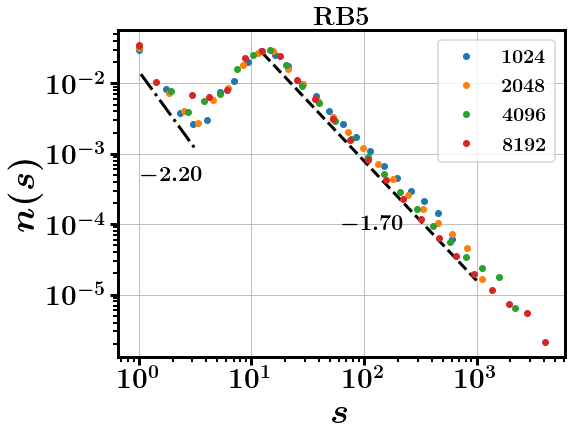

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)      
ax.set_title(attack_dict[attack], fontsize=26)
ax.grid(True)

X = np.logspace(1.1, 3.)
a = -1.7
c = 2
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.5, 0.4, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

X = np.logspace(0.02, 0.5)
a = -2.2
c = .015
Y = powerlaw(X, a, c)
ax.plot(X, Y, '-.', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.05, 0.55, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)
for N in N_values:
    comp_sizes = all_comp_sizes[N]
    X, Y = get_histo(comp_sizes, nbins=25)
    
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N))
    
ax.legend(loc='upper right', fontsize=20)

fig_name = os.path.join(fig_dir, 'comp_sizes_RB5_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

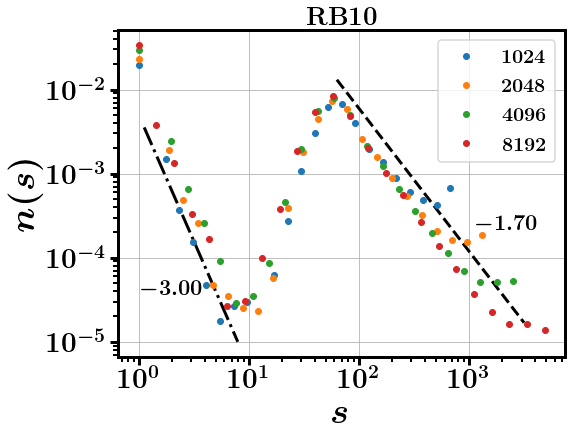

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.set_title(attack_dict[attack], fontsize=26)
ax.grid(True)

X = np.logspace(1.8, 3.5)
a = -1.7
c = 15
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.8, 0.4, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

X = np.logspace(0.05, 0.9)
a = -3
c = .005
Y = powerlaw(X, a, c)
ax.plot(X, Y, '-.', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.05, 0.2, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)
for N in N_values:
    comp_sizes = all_comp_sizes[N]
    X, Y = get_histo(comp_sizes, nbins=25)
    
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N))
    
ax.legend(loc='upper right', fontsize=20)

fig_name = os.path.join(fig_dir, 'comp_sizes_RB10_{}_0'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)      
ax.set_title(attack_dict[attack], fontsize=26)
ax.grid(True)

X = np.logspace(1.8, 3.5)
a = -1.7
c = 15
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.8, 0.4, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

X = np.logspace(0.05, 0.9)
a = -3
c = .005
Y = powerlaw(X, a, c)
ax.plot(X, Y, '-.', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.05, 0.2, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)
for N in N_values:
    comp_sizes = all_comp_sizes[N]
    X, Y = get_histo(comp_sizes, nbins=25)
    
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N))
    
ax.legend(loc='upper right', fontsize=20)

fig_name = os.path.join(fig_dir, 'comp_sizes_RB10_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

1024 765650	76.58031606321263
4096 788100	78.8257651530306
16384 186000	78.91387356809503


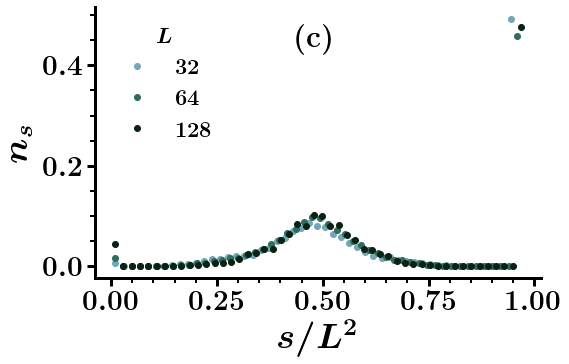

In [85]:
_N_values = [1024, 4096, 16384]

colormap = sns.cubehelix_palette(
    len(f_values), start=2, rot=0.3, light=0.6, dark=0.1
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.despine()
#ax.set_xscale('log')
#ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
#ax.set_title(attack_dict[attack], fontsize=26)
ax.text(0.45, 0.85, letters[2], transform=ax.transAxes, fontsize=30)

l_cutoff = {
    1024: 25,
    2048: 33,
    4096: 42,
    8192: 54
}


for i, N in enumerate(_N_values):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50
    #X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    hist, bin_edges = np.histogram(comp_sizes, bins=nbins, density=False)
    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist
    
    #mask = X>1
    #X = X[mask]
    #Y = Y[mask]

    print(N, Y.sum()*nbins, end='\t')
    
    X = X / N
    Y = Y / nseeds

    dX = X[1] - X[0]
    print(Y.sum()*nbins)
    
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(int(np.sqrt(N))), color=colormap[i])
    #ax.axvline(l_cutoff[N], color=f'C{i}')

legend = ax.legend(loc='upper left', fontsize=22, frameon=False)
legend.set_title(r'$L$', prop={'size':22})

fig_name = os.path.join(fig_dir, 'PRL_comp_sizes_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

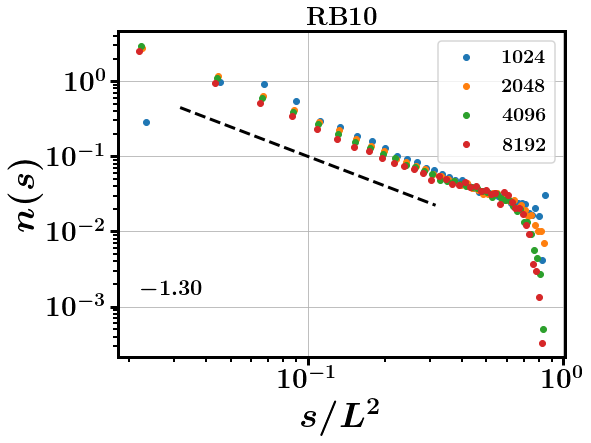

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.set_title(attack_dict[attack], fontsize=26)
ax.grid(True)

l_cutoff = {
    1024: 25,
    2048: 33,
    4096: 42,
    8192: 54
}

for i, N in enumerate(N_values):
    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    X, Y = get_histo(comp_sizes, nbins=40, log=False, density=False)
    mask = X>1
    X = X[mask]
    Y = Y[mask]
    
    X = X / N
    Y = Y / nseeds
    
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N), color=f'C{i}')
    #ax.axvline(l_cutoff[N], color=f'C{i}')

X = np.logspace(-1.5, -0.5)
a = -1.3
c = .005
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.05, 0.2, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)
    
ax.legend(loc='upper right', fontsize=20)

fig_name = os.path.join(fig_dir, 'comp_sizes_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [56]:
f_values_dict = {}
    
f_values_dict[16384] = {
    "BtwU": ["0.02202", "0.02985", "0.02692"]
    }    
    
f_values_dict[8192] = {
    "BtwU": ["0.02633", "0.03650", "0.03198"],
    "BtwU_cutoff2": ["0.33537", "0.33813", "0.34106"],
    "BtwU_cutoff3": ["0.28012", "0.28259", "0.28442"],
    "BtwU_cutoff4": ["0.25069", "0.25183", "0.25476"],
    "BtwU_cutoff5": ["0.22539", "0.22754", "0.22961"],
    "BtwU_cutoff6": ["0.20464", "0.20618", "0.20801"],
    "BtwU_cutoff10": ["0.14397", "0.14490", "0.14819"],
    "BtwU_cutoff11": ["0.13367", "0.13403", "0.13843"],
    "BtwU_cutoff12": ["0.12413", "0.12598", "0.12769"],
    "BtwU_cutoff13": ["0.11607", "0.11670", "0.12158"],
    "BtwU_cutoff14": ["0.10764", "0.10864", "0.11365"],
    "BtwU_cutoff15": ["0.10160", "0.10181", "0.10706"],
    #"BtwU_cutoff16": ["0.09571", "0.09534", "0.10156"],
    "BtwU_cutoff16": ["0.09534", "0.09534", "0.10156"],
    "BtwU_cutoff54": ["0.02644", "0.03711", "0.03259"]
}

f_values_dict[4096] = {
    "BtwU": ["0.03188", "0.04663", "0.03882"],
    "BtwU_cutoff2": ["0.33373", "0.33594", "0.33887"],
    "BtwU_cutoff3": ["0.27857", "0.28076", "0.28540"],
    "BtwU_cutoff4": ["0.24841", "0.24951", "0.25464"],
    "BtwU_cutoff5": ["0.22305", "0.22510", "0.22803"],
    "BtwU_cutoff6": ["0.20151", "0.20288", "0.20703"],
    "BtwU_cutoff7": ["0.18301", "0.18506", "0.18823"],
    "BtwU_cutoff8": ["0.16664", "0.16797", "0.17334"],
    "BtwU_cutoff9": ["0.15233", "0.15259", "0.15796"],
    "BtwU_cutoff10": ["0.13978", "0.14160", "0.14600"],
    "BtwU_cutoff11": ["0.12871", "0.13062", "0.13403"],
    "BtwU_cutoff12": ["0.11903", "0.12158", "0.12451"],
    "BtwU_cutoff13": ["0.11023", "0.11328", "0.11646"],
    "BtwU_cutoff14": ["0.10261", "0.10571", "0.10913"],
    "BtwU_cutoff15": ["0.09549", "0.09937", "0.10156"]
}

f_values_dict[2048] = {
    "BtwU": ["0.03875", "0.05469", "0.04834"],
    "BtwU_cutoff2": ["0.33160", "0.33496", "0.34082"],
    "BtwU_cutoff3": ["0.27621", "0.27881", "0.28418"],
    "BtwU_cutoff4": ["0.24570", "0.24854", "0.25391"],
    "BtwU_cutoff5": ["0.21983", "0.22217", "0.22852"],
    "BtwU_cutoff6": ["0.19722", "0.20020", "0.20557"],
    "BtwU_cutoff7": ["0.17822", "0.18262", "0.18604"],
    "BtwU_cutoff8": ["0.16167", "0.16455", "0.17041"],
    "BtwU_cutoff9": ["0.14669", "0.15039", "0.15381"],
    "BtwU_cutoff10": ["0.13349", "0.13818", "0.14160"],
    "BtwU_cutoff11": ["0.12198", "0.12695", "0.12939"],
    "BtwU_cutoff12": ["0.11173", "0.11621", "0.11865"],
    "BtwU_cutoff13": ["0.10238", "0.10840", "0.11133"],
    "BtwU_cutoff14": ["0.09468", "0.10205", "0.10303"],
    "BtwU_cutoff15": ["0.08740", "0.09570", "0.09717"]
}

f_values_dict[1024] = {
    "BtwU": ["0.04775", "0.06836", "0.05859"],
    "BtwU_cutoff2": ["0.32875", "0.33496", "0.34180"],
    "BtwU_cutoff3": ["0.27325", "0.27734", "0.28223"],
    "BtwU_cutoff4": ["0.24177", "0.24707", "0.25195"],
    "BtwU_cutoff5": ["0.21514", "0.21875", "0.22559"],
    "BtwU_cutoff6": ["0.19225", "0.19824", "0.20215"],
    "BtwU_cutoff7": ["0.17170", "0.17969", "0.18164"],
    "BtwU_cutoff8": ["0.15393", "0.15918", "0.16406"],
    "BtwU_cutoff9": ["0.13830", "0.14648", "0.14844"],
    "BtwU_cutoff10": ["0.12457", "0.13379", "0.13477"],
    "BtwU_cutoff11": ["0.11217", "0.12305", "0.12500"],
    "BtwU_cutoff12": ["0.10111", "0.11523", "0.11328"],
    "BtwU_cutoff13": ["0.09111", "0.10547", "0.10254"],
    "BtwU_cutoff14": ["0.08228", "0.09766", "0.09668"],
    "BtwU_cutoff15": ["0.07445", "0.09180", "0.08984"]
}

all_comp_sizes = {}
nseeds_values = {}

gcc = True

N_values = [8192]
attacks = [f'BtwU_cutoff{l}' for l in [2, 4, 10, 16, 54]]
for attack in attacks:

    for N in N_values:

        all_comp_sizes[attack] = {}
        nseeds_values[attack] = {}

        f_value = f_values_dict[N][attack][0]
        print(attack, N, f_value)
        net_dir_name = '../networks/DT/DT_param'.format(param)
        base_net_name = 'DT_param_N{}'.format(N)
        base_net_dir_name = os.path.join(net_dir_name, base_net_name)
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
            seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
            seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

        nseeds_values[attack][N] = nseeds
        all_comp_sizes[attack][N] = comp_sizes
    

BtwU_cutoff2 8192 0.33537
BtwU_cutoff4 8192 0.25069
BtwU_cutoff10 8192 0.14397
BtwU_cutoff16 8192 0.09534
BtwU_cutoff54 8192 0.02644


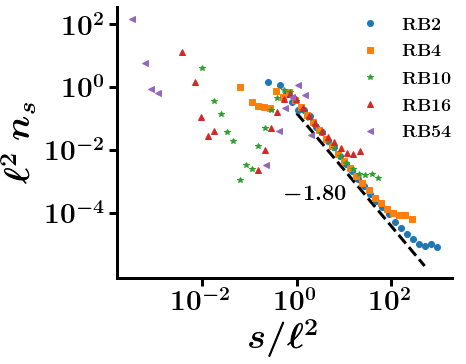

In [60]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.despine()
ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
#ax.set_xlabel(r'$s/\ell^2$', fontsize=36)
#ax.set_ylabel(r'$\ell^2\;n_s$', fontsize=36)   

ax.set_xticks([0.01, 1, 100])
ax.set_yticks([1e-4, 1e-2, 1, 1e2])

ax.set_xlabel(r'$s/\ell^2$', fontsize=36)
ax.set_ylabel(r'$\ell^2\;n_s$', fontsize=36)    

X = np.logspace(0., 2.7)
a = -1.8
c = 0.15
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.5, 0.3, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

N = 8192
l_values = [2, 4, 10, 16, 54]

markers = ['o', 's', '*', '^', '<', '>']
for i, attack in enumerate(attacks):
    comp_sizes = all_comp_sizes[attack][N]
    X, Y = get_histo(comp_sizes, nbins=30)
    
    X = X / l_values[i]**2
    Y = Y * l_values[i]**2

    ax.plot(X, Y, marker=markers[i], linestyle='', label=attack_dict[attack])
    
ax.legend(loc=(0.68, 0.48), fontsize=18, frameon=False)
#ax.legend(loc=(0.05, 0.2), fontsize=18)
#ax.axvline(0.5)
fig_name = os.path.join(fig_dir, 'collapse2'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

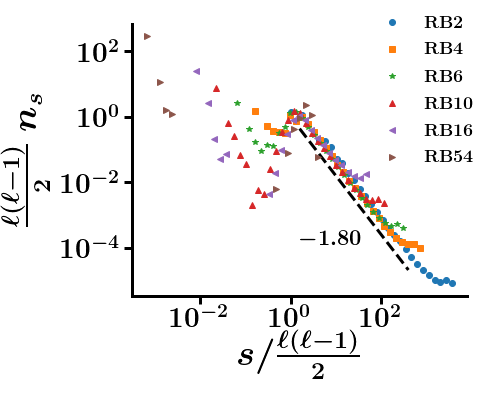

In [48]:
fig, ax = plt.subplots(figsize=(6,5))

sns.despine()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([0.01, 1, 100])
ax.set_yticks([1e-4, 1e-2, 1, 1e2])

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
#ax.set_xlabel(r'$s/\ell^2$', fontsize=36)
#ax.set_ylabel(r'$\ell^2\;n_s$', fontsize=36)    

ax.set_xlabel(r'$s/\frac{\ell(\ell-1)}{2}$', fontsize=36)
ax.set_ylabel(r'$\frac{\ell(\ell-1)}{2}\;n_s$', fontsize=36)    

X = np.logspace(0.2, 2.6)
a = -1.8
c = 1
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.5, 0.2, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

N = 8192
l_values = [2, 4, 6, 10, 16, 54]

markers = ['o', 's', '*', '^', '<', '>']
for i, attack in enumerate(attacks):
    comp_sizes = all_comp_sizes[attack][N]
    X, Y = get_histo(comp_sizes, nbins=30)
    
    #X = X / l_values[i]**2
    #Y = Y * l_values[i]**2
    
    X = 2*X / (l_values[i]*(l_values[i]-1))
    Y = 2*Y * (l_values[i]*(l_values[i]-1))
    
    ax.plot(X, Y, marker=markers[i], linestyle='', label=attack_dict[attack])
    
ax.legend(loc=(0.7, 0.45), fontsize=18, frameon=False)
#ax.axvline(0.5)
fig_name = os.path.join(fig_dir, 'collapse1'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

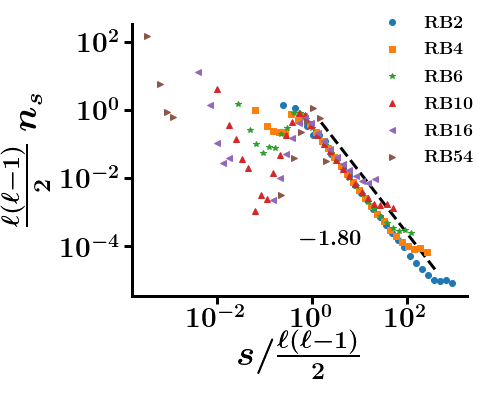

In [54]:
fig, ax = plt.subplots(figsize=(6,5))

sns.despine()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([0.01, 1, 100])
ax.set_yticks([1e-4, 1e-2, 1, 1e2])

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
#ax.set_xlabel(r'$s/\ell^2$', fontsize=36)
#ax.set_ylabel(r'$\ell^2\;n_s$', fontsize=36)    

ax.set_xlabel(r'$s/\frac{\ell(\ell-1)}{2}$', fontsize=36)
ax.set_ylabel(r'$\frac{\ell(\ell-1)}{2}\;n_s$', fontsize=36)    

X = np.logspace(0.2, 2.6)
a = -1.8
c = 1
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')#, label=r'${{{:.2f}}}$'.format(a))
ax.text(0.5, 0.2, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

N = 8192
l_values = [2, 4, 6, 10, 16, 54]

markers = ['o', 's', '*', '^', '<', '>']
for i, attack in enumerate(attacks):
    comp_sizes = all_comp_sizes[attack][N]
    X, Y = get_histo(comp_sizes, nbins=30)
    
    #X = X / l_values[i]**2
    #Y = Y * l_values[i]**2
    
    X = X / l_values[i]**2
    Y = Y * l_values[i]**2
    
    ax.plot(X, Y, marker=markers[i], linestyle='', label=attack_dict[attack])
    
ax.legend(loc=(0.7, 0.45), fontsize=18, frameon=False)
#ax.axvline(0.5)
fig_name = os.path.join(fig_dir, 'collapse3'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [115]:
all_comp_sizes = {}
nseeds_values = {}

gcc = True
attack = 'BtwU'
N_values = [2048, 4096, 8192]
for N in N_values:
    print(N)
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    comp_sizes_file = 'comp_sizes_delta_{}.txt'.format(attack, f_value)
    seeds_file = 'comp_sizes_delta_{}_seeds.txt'.format(attack, f_value)

    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes
    

2048
4096
8192


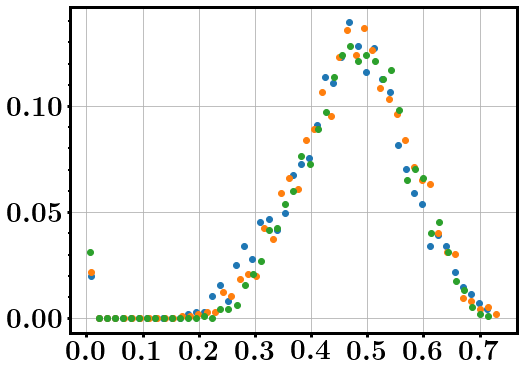

In [116]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
for N in N_values:
    comp_sizes = all_comp_sizes[N]
    hist, bin_edges = np.histogram(comp_sizes, bins=50)

    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist
    
    X = X / N
    Y = Y / nseeds
    ax.plot(X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N))
    
plt.show()